# Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd

In [5]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

In [6]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [7]:
from sklearn.model_selection import TimeSeriesSplit

In [2]:
international_airline_passengers = pd.read_csv("international-airline-passengers.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

Сперва берем датасет в котором прослеживается положительный тренд и сезонность

In [4]:
series = international_airline_passengers["Count"]

In [11]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

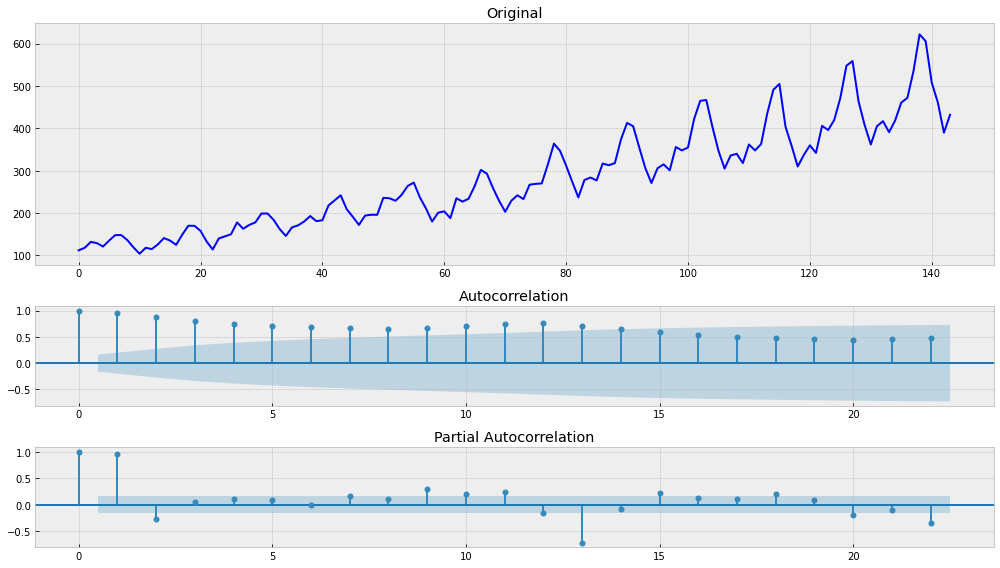

In [12]:
tsplot(series)

In [8]:
train, val = series[:120], series[120:]

Т.к. есть тренд и сезонность используем метод Хольт-Винтерс

In [13]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [14]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [15]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [20]:
def plot_tema(alpha, beta, gamma, ser=international_airline_passengers["Count"], ser_to_plot=international_airline_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

кросс-валидация

In [16]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [17]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

C:\Users\CoreI7\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


33520.81576987681------------
33069.4665622985------------
33520.81576987681------------
33483.77624026587------------
33197.675758210455------------
32983.09337367265------------
32721.653165564105------------
32524.111790476643------------
32069.969699473233------------
32043.242392754124------------
31488.758806980313------------
31174.81510837054------------
30327.10519820734------------
29962.75412627308------------
28773.88994740133------------
28442.137661480316------------
26937.968755491234------------
26361.25663735472------------
24605.084728513306------------
23861.707545655332------------
21865.200082574567------------
21347.277187127227------------
19676.635717252055------------
19528.4993932338------------
19269.88854786022------------
18656.679754686604------------
20181.854161825864------------
20527.881196311617------------
19212.76123403994------------
21690.4721602599------------
18869.532634836232------------
18306.22643615588------------
17840.01633740427---------

478.2019566870841------------
469.1306801505522------------
461.43080666694686------------
457.5588325626139------------
461.4716783894058------------
455.4998321430783------------
453.287825968076------------
450.67960205016396------------
452.85070559747345------------
453.3796002908395------------
447.27757138159876------------
446.0696059369374------------
446.2956840281925------------
447.5503335899925------------
440.2164166867357------------
439.7308507500595------------
451.58106521105674------------
442.0203157591159------------
445.6154425341426------------
439.5963645585426------------
450.93125252231295------------
451.8800717749036------------
440.46433278459745------------
443.01218686427364------------
439.5837273712532------------
441.04570524769133------------
439.2931780788938------------
440.36824545121317------------
439.06466265145036------------
441.9417262539402------------
438.8551852750373------------
439.1565828933749------------
438.6957776287389------------


In [18]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[0.02722178, 0.32635344, 1.44178296],
       [0.0272219 , 0.32631267, 1.44177985],
       [0.02721701, 0.326416  , 1.4417996 ],
       [0.027222  , 0.32637211, 1.44174298]]), array([438.6703981 , 438.67039883, 438.67039889, 438.67040022]))
           fun: 438.67039810088414
       message: 'Optimization terminated successfully.'
          nfev: 402
           nit: 230
        status: 0
       success: True
             x: array([0.02722178, 0.32635344, 1.44178296])


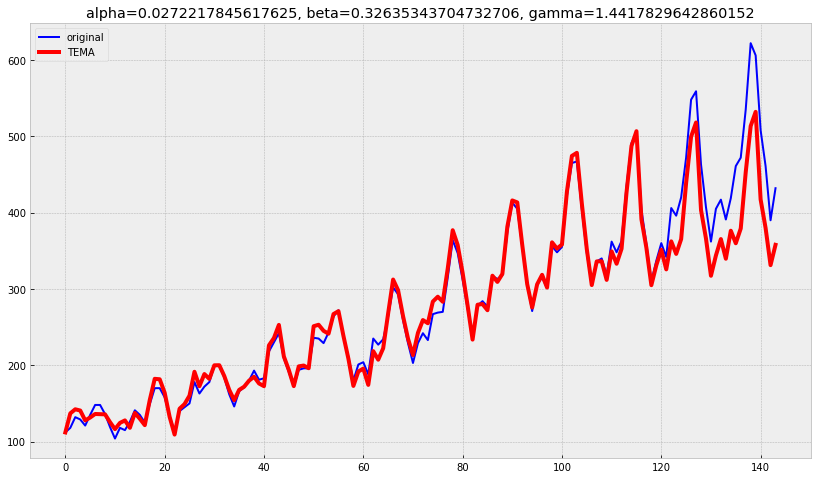

In [21]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Получилось похоже. Сезонность учлась. Тренд немного похуже, но тоже заметен.

Дальше приводим наш ряд в стационарный

In [22]:
International_airline_passengers = boxcox(series, 0)

In [23]:
International_airline_passengers = np.diff(International_airline_passengers, 1)

In [24]:
International_airline_passengers = International_airline_passengers[12:] - International_airline_passengers[:-12]

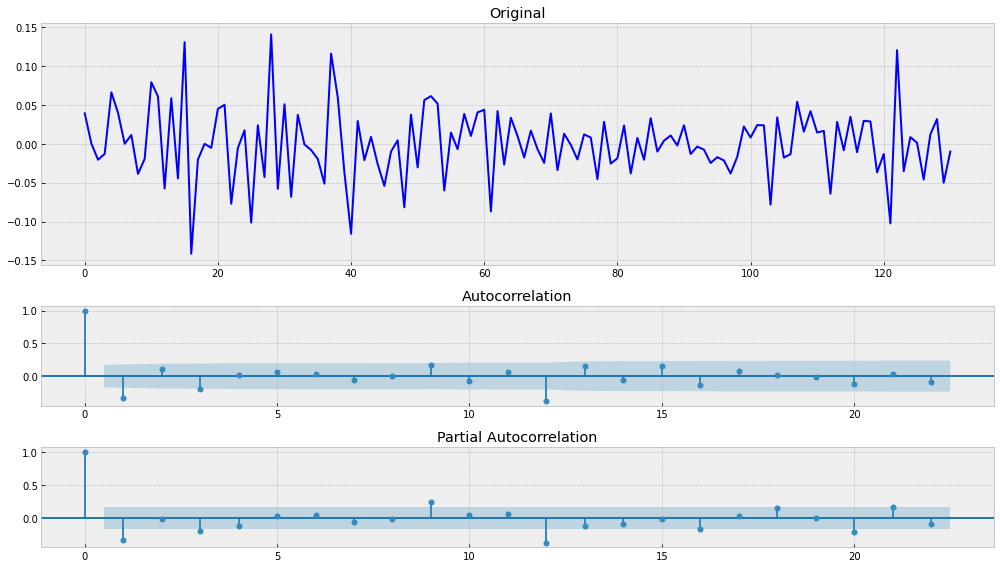

In [26]:
tsplot(International_airline_passengers)

In [27]:
International_airline_passengers = pd.DataFrame(International_airline_passengers)

In [28]:
train_i, val_i = International_airline_passengers[:120], International_airline_passengers[120:]

In [29]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [30]:
def ex_cross_val(X):
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = exponential_moving_average(international_airline_passengers["Count"], 0.2)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [33]:
opt_i = minimize(ex_cross_val, x0=[0,0,0], method="Nelder-Mead")

28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------
28271.78790070857------------


In [36]:
alpha_opt_i = opt_i.x
print(opt_i)

 final_simplex: (array([[0.00e+00, 0.00e+00, 0.00e+00],
       [6.25e-05, 0.00e+00, 0.00e+00],
       [0.00e+00, 6.25e-05, 0.00e+00],
       [0.00e+00, 0.00e+00, 6.25e-05]]), array([28271.78790071, 28271.78790071, 28271.78790071, 28271.78790071]))
           fun: 28271.78790070857
       message: 'Optimization terminated successfully.'
          nfev: 14
           nit: 3
        status: 0
       success: True
             x: array([0., 0., 0.])


большая ошибка, всё сгладилось

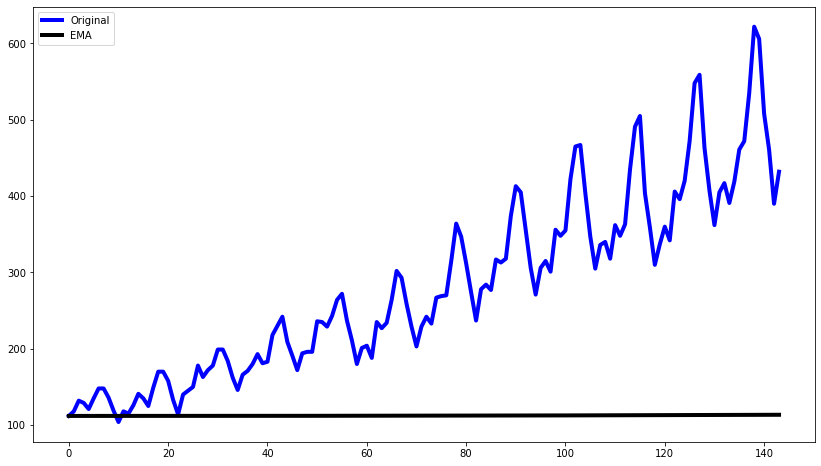

In [50]:

plt.figure(figsize=(14, 8))
plt.plot(i, color='blue', linewidth='4', label='Original')
plt.plot(ema, color='black', linewidth='4', label='EMA')
plt.legend()

In [43]:
i = international_airline_passengers["Count"]

In [49]:
ema = exponential_moving_average(i, 6.25e-05)